# Introduction to Image Classification

### *By Donovan Lo, Booz Allen Hamilton*
### *<lo_donovan@bah.com>*

---

*Booz Allen Hamilton Inc. Proprietary and Confidential Information. The information provided herein contains Booz Allen Hamilton proprietary, confidential, and trade secret information and is provided solely for the client identified for informational and/or evaluation purposes only. The information contained in this document/briefing shall not be duplicated, used, or disclosed in whole or in part without the express written permission of an authorized officer of Booz Allen Hamilton.*

---
<img src="notebook_images/cnn_layers_1.png" width="700">

## Overview

In this tutorial, we will build an image classifier model using convolutional neural network to distinguish dogs and cats in an image. Image classifier is a computer vision model that takes the pixels in the input image and performs a series of matrix multiplication and summation. The result from the series of matrix operation is a list of confidence values for the classes of interest. Image classification is helpful tool to categorize, index, and allow for search and retrival in many different industry applications. 

In this tutorial, we will go over the following:
- Components of CNN
- Build Simple CNN
- What is CNN learning ?

## Pre-requisites

Download the [Dogs vs Cats dataset](https://www.kaggle.com/c/dogs-vs-cats).
The tutorial uses Python 2.7 and requires the following Python libraries:
- Tensorflow
- Keras
- numpy
- cv2
- pylab
- skrimage
- scipy
- tqdm
- imutils

If you are missing any of the packages and you are using Linux or Mac OS, use "__pip install [package_name]__" in your terminal to perform the package installations. [__pip__](https://pip.pypa.io/en/stable/installing/) is already installed if you are using Python 2 >=2.7.9 or Python 3 >=3.4 binaries. 

### Imports

In [1]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from imutils import paths
from shutil import copyfile
import os, cv2, random
import numpy as np
import pylab as pl
from tqdm import *
random.seed(13)

import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

/Users/donovanlo/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data

We will be using the Dogs vs Cats Dataset. This dataset stemmed from the Asirra challenge. Asirra (Animal Species Image Recognition for Restricting Access) is a HIP (Human Interactive Proof) that help protects web services from bot attempts. HIP are difficult for computers but easy for humans. For this tutorial, the dataset can be downloaded at Kaggle's [Dogs vs Cats dataset](https://www.kaggle.com/c/dogs-vs-cats)

__KEY__: After the dataset has been downloaded, define the absolute path to the __Dogs_vs_Cats'__ train folder. 

We will split the data into a train and validation folder. The validation set will not be used for training. The purpose of validation set is to verify the accuracy of the model on unseen data. 

In [ ]:
# Path to the Dogs vs Cats train folder
path_to_data = "/Users/donovanlo/Documents/__Tools/data/Dogs_vs_Cats/train"

In [3]:
# Dimension of input images
img_width, img_height = 150, 150
nb_train_samples = 16000     #2000
nb_validation_samples = 6400 #800
# Path to the data
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

imagePaths = list(paths.list_images(path_to_data))

dogs_list = []
cats_list = []

for (i, imagePath) in tqdm(enumerate(imagePaths)):
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    file_name = imagePath.split(os.path.sep)[-1]
    if label == "dog":
        dogs_list.append( imagePath )
    else:
        cats_list.append( imagePath )

random.shuffle(dogs_list)
random.shuffle(cats_list)

def copy_nb_files(src_list,num,dst_folder):
    os.makedirs(dst_folder)
    for i in range(num):
        src = src_list[i]
        dst = os.path.join(dst_folder,src_list[i].split(os.path.sep)[-1])
        copyfile(src,dst)
        
nb_tr_samples = nb_train_samples/2
nb_va_samples = nb_validation_samples/2
# Create train/dogs and train/cats folder
if not os.path.exists(train_data_dir):
    copy_nb_files(dogs_list[:nb_tr_samples], nb_tr_samples, train_data_dir+"/dogs")
    copy_nb_files(cats_list[:nb_tr_samples], nb_tr_samples, train_data_dir+"/cats")

# Create validation/dogs and validation/cats folder
if not os.path.exists(validation_data_dir):
    copy_nb_files(dogs_list[nb_tr_samples+1:nb_tr_samples+nb_va_samples+1], nb_va_samples, validation_data_dir+"/dogs")
    copy_nb_files(cats_list[nb_tr_samples+1:nb_tr_samples+nb_va_samples+1], nb_va_samples, validation_data_dir+"/cats")

25000it [00:00, 366278.93it/s]


We will use the [__ImageDataGenerator__](https://keras.io/preprocessing/image/) function to create data generators. The generator will load the feed batches of input images to the cnn model. 

In [4]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

# Rescale the pixel values from [0,255] to [0,1]
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_data_dir, 
    target_size=(img_width,img_height), 
    batch_size=batch_size, 
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    validation_data_dir, 
    target_size=(img_width,img_height), 
    batch_size=batch_size, 
    class_mode='binary')

Found 16000 images belonging to 2 classes.
Found 6400 images belonging to 2 classes.


# Model

## Convolutional Neural Network (CNN)
Convolutional Neural Network is a special case of linear Neural Network. Unlike the linear Neural Network, the neurons in the layer are 3 dimensional which captures width, height, and depth. In the case of linear Neural Network, the input is one hot vector of 1xN array. The input images that we will be feeding to the CNN has the dimension of 150x150x3 (width,height,depth of rgb channel).  

![img1](notebook_images/cnn.png)

## Layers of CNN
CNN consists of five main components:

- __Input_Image__: The input image is seen by the computer as a volumn (width,height,depth) of numbers.
<img src="notebook_images/input_image.png" width="500">
- __CONV layer__ : Convolution layer consists of a set of learned filters. In inference, the input image is dot producted with each of the filter to produce the activation features. The learned filters dictate what features in the input image is extracted and fed to the next layer. The features are updated during Back-Propogation.
<img src="notebook_images/convolution.png" width="350">
- __RELU layer__ : RELU stands for Rectified Linear Units. This layer applies a nonlinear activation function of f(x)=max(0,x). Activation funtion is a decision function that drives a value towards a High (1) or a Low (0) value. There are other activation functions that can replace the RELU such as sigmoid, and tanh. 
<img src="notebook_images/activation_function.png" width="500">
- __POOL layer__ : This layer is a non-linear downsampling. The pooling function partitions the input image into sub-region. Each sub-region is computes to a single value either by the max, average, or min function. 
<img src="notebook_images/pooling.png" width="200">
- __FC layer__ : The Fully Connected layer allows the model to output the decision in a linear vector. It connects all the previous neuron activations to each neuron in this layer. Each of the elements in the vector is a class score. 

<img src="notebook_images/cnn_layers_2.png" width="700">

## Build a Simple CNN

### Model architecture definition

In [5]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))

model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Uncomment this if you would like to see the graph visualization of model 
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

model.summary()

/Users/donovanlo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(150, 150,...)`
  
/Users/donovanlo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  """
/Users/donovanlo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  if __name__ == '__main__':


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
act

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Training

We will perform our training below on 16000 training samples. I am using my MacBook Pro's CPU to do the training, which took __~9 minutes__ to run. 

In [ ]:
nb_epoch = 1

model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

/Users/donovanlo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/Users/donovanlo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=500, epochs=1, validation_steps=6400)`
  


Epoch 1/1
499/500 [============================>.] - ETA: 1s - loss: 0.6743 - acc: 0.6120

When we first initialize our image classification model, the weights in the model's convolutional layer are random. These weights are updated in a training process called __backpropagation__ . __Backpropagation__ is broken in to 4 process:

- __Forward Pass:__ Each training image of dimension 150x150x3 is passed through the CNN. Since the weights are randomly initialized, the prediction of the network would not be reasonable. The poor prediction will be fed to the loss function. 
- __Loss Function:__ Each training image is associated with a label. For example, an image of a dog will have the label as [1] and image of a cat have the label [0]. There different definition for the loss function. The most common loss function used is the MSE (mean squared error). If the predicted label and the trained label are different the loss will be high, and conversely. To get the model to predict correctly, we would like to minimize this loss by changing the weights that most contribute to the loss. This minimization of the error or the optimization of the network is expressed as __dL/dW__ where __L__ is the loss and __W__ are the weights at a layer.
\begin{equation*}
L = E_{total} = \sum \frac{1}{2} (actual - predicted)^2
\end{equation*}
- __Backward Pass:__ In this process, we compute the derivative to determine which weights contributed the most to the loss, so they can be adjusted. 
- __Weight Update:__ The adjustment of weights value are changed opposite direction of the gradient. 

<img src="notebook_images/backpropagation.png" width="500">
                   (__Ref__: *K. Audhkhasi, Backpropagation - "Noise-enhanced convolutional neural networks"*)

The __backpropagation__ is performed for one training iteration. The backpropagation is performed numerous of times for each set of training images, called __epoch__, until the network is updated with high enough validation accuracy.

You can save the model's weights here so you do not have to re-train your model everytime you would like to do inference. You can simply load the weights and restore the model from where you left it.

In [17]:
model.save_weights('model-2000-samples--1-epochs.h5')

### Testing

Let's first load our trained weights in to the model and the first 1000 test images from the test directory to a List. 

In [87]:
model.load_weights('model-2000-samples--1-epochs.h5')

test_dir = '/Users/donovanlo/Documents/__Tools/data/Dogs_vs_Cats/test1'
test_images = [test_dir+'/'+i for i in os.listdir(test_dir)]
random.shuffle(test_images)
test_images = test_images[:1000]
count = len(test_images)
test_data = np.ndarray((count,3,img_width,img_height), dtype=np.uint8)
for i, image_file in enumerate(test_images):
    img = cv2.imread(image_file, cv2.IMREAD_COLOR)
    b, g, r = cv2.split(img)
    img2 = cv2.merge([r,g,b])
    image = cv2.resize(img2, (img_width, img_height), interpolation=cv2.INTER_CUBIC)
    test_data[i] = image.T

After the test images has been loaded to a List, we will pick the first test image as our test sample. By feeding the image to the model, it performs a forward propogation through the series of CONV, RELU, POOL, and FC layer. The output of the CNN is a single value of either 0 or 1. Value of 1 translates to a Dog and 0 to a Cat.

The model thinks the image is a Dog.


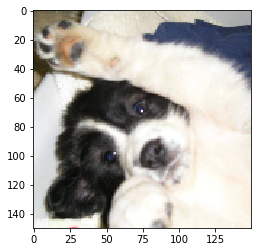

In [95]:
test_image = test_data[0].T
plt.imshow(test_image,cmap='binary')
prediction = model.predict( np.expand_dims(test_image,axis=0) )

if prediction[0][0] == 1:
    print('The model thinks the image is a Dog.')
else:
    print('The model thinks the image is a Cat.')

Nicely Done! Since our validation accuracy is 53% over 1 epoch, our model got really lucky. To improve the validation accuracy, try changing the __epoch__ from 1 to 30 in the training section. This will take some time on CPU, but it will be worth it.  

### Explore convnet filters

Here we will take a dive and see what the deep convolutional neural network (convnets) has learned. When we say "learned", we are saying what the weights (or values) in the filter as been updated to. Each filter are features the model would like to learn such as edges, texture, part of the body, and body of interest. 

As seen below the filter in the lower layers has features such as horizontal and vertical lines. For each feature found in the image from the previous layer will be responsible in generating a larger activation for the next layer. For example, the activation found with different angle lines froms the nose, eye, or mouth. Those features of nose, eye, and mouth froms the larger activation of different faces in the next layer. 


<img src="notebook_images/feature_learning.png" width="700">

Let's look at what features and activation output our model generates. First we need to extract each of the model's layer as objects.

In [18]:
# get the symbolic outputs of each 'key' layer
layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_dict

{'activation_10': <keras.layers.core.Activation at 0x11d890750>,
 'activation_6': <keras.layers.core.Activation at 0x11d530790>,
 'activation_7': <keras.layers.core.Activation at 0x11d7a6710>,
 'activation_8': <keras.layers.core.Activation at 0x11d7cdcd0>,
 'activation_9': <keras.layers.core.Activation at 0x11d860650>,
 'conv2d_4': <keras.layers.convolutional.Conv2D at 0x11d7cd850>,
 'conv2d_5': <keras.layers.convolutional.Conv2D at 0x11d7f8910>,
 'conv2d_6': <keras.layers.convolutional.Conv2D at 0x11d7f8110>,
 'dense_3': <keras.layers.core.Dense at 0x11d870ed0>,
 'dense_4': <keras.layers.core.Dense at 0x11d89ff90>,
 'dropout_2': <keras.layers.core.Dropout at 0x11d860e10>,
 'flatten_2': <keras.layers.core.Flatten at 0x11d847d50>,
 'max_pooling2d_3': <keras.layers.pooling.MaxPooling2D at 0x11d7a6e10>,
 'max_pooling2d_4': <keras.layers.pooling.MaxPooling2D at 0x11d7cded0>}

Next we will convert each of the convolution layers of interest into a function. The functions will be called later with an input of the image. 

In [96]:
from keras import backend as K
inputs = [K.learning_phase()] + model.inputs

_convout6_f = K.function(inputs, [layer_dict['activation_6'].output])
_convout7_f = K.function(inputs, [layer_dict['activation_7'].output])
_convout8_f = K.function(inputs, [layer_dict['activation_8'].output])
def convout4_f(X):
    return _convout6_f([0]+[X])
def convout5_f(X):
    return _convout7_f([0]+[X])
def convout6_f(X):
    return _convout8_f([0]+[X])

We will define some helper functions to visualize all the filters at a particular layer or the activation output from a layer.

In [30]:
# utility functions
from mpl_toolkits.axes_grid1 import make_axes_locatable

def nice_imshow(ax, data, vmin=None, vmax=None, cmap=None):
    """Wrapper around pl.imshow"""
    if cmap is None:
        cmap = cm.jet
    if vmin is None:
        vmin = data.min()
    if vmax is None:
        vmax = data.max()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    im = ax.imshow(data, vmin=vmin, vmax=vmax, interpolation='nearest', cmap=cmap)
    pl.colorbar(im, cax=cax)
    
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i].T
    return mosaic

Let's look at our model again to remind ourselves what it looks. 

The first line shows us that the model takes an input image (width,height) of 148 x 148. At the __conv2d_4 (Conv2D)__ layer, there are 32 filters ready for learning features. Each filter in this layer is 3x3. Each of the filters will learn values to capture features to assist the final decision in the classifcation layer.


|conv2d_X | [AxAxB]    |    weights: (filter_w x filter_h x previous_neurons)x(current_neurons) + bias |
|------|------|
|Input:  | [150x150x3] |   weights: 0 |
|conv2d_4 | [148x148x32]   | weights: (3x3x3)x32 + 32  = 896 | 
|conv2d_5 | [146x146x32]   |  weights: (3x3x32)x32 + 32 = 9248 | 
|conv2d_6 | [71x71x64]    |   weights: (3x3x32)x64 + 64 = 18496 | 
|dense_3  | [None, 64]    |   weights: (1x1x78400)x64 + 64 = 5017664  | 
|dense_4  | [None, 1]     |   weights: (1x1x64)x1 + 1 = 65 | 

In [102]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
activation_7 (Activation)    (None, 146, 146, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 71, 71, 64)        0         
__________

Let's examine what the 32 3x3 filters look like in the first convolutonal layer (conv2d_4). 

('W shape : ', (32, 3, 3))


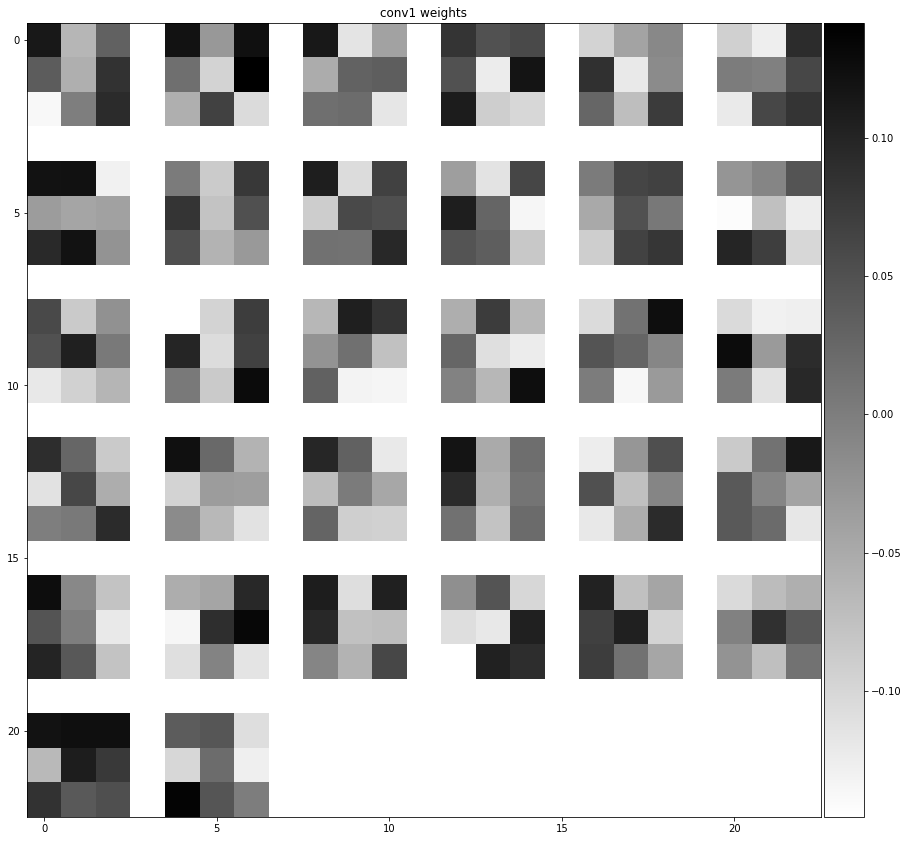

In [89]:
# Visualize weights in the first Convolutional Layer
W = layer_dict['conv2d_4'].get_weights()[0][:,:,0,:]
W = np.squeeze(W)
print("W shape : ", W.T.shape)

pl.figure(figsize=(15, 15))
pl.title('conv1 weights')
nice_imshow(pl.gca(), make_mosaic(W.T, 6, 6), cmap=cm.binary)

Let's examine what the output looks like after the input is convolved with each of the 32 filters followed by the RELU activation function.

('C4 shape : ', (32, 148, 148))


/Users/donovanlo/anaconda2/envs/py2_opencv_contrib/lib/python2.7/site-packages/matplotlib/colors.py:860: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


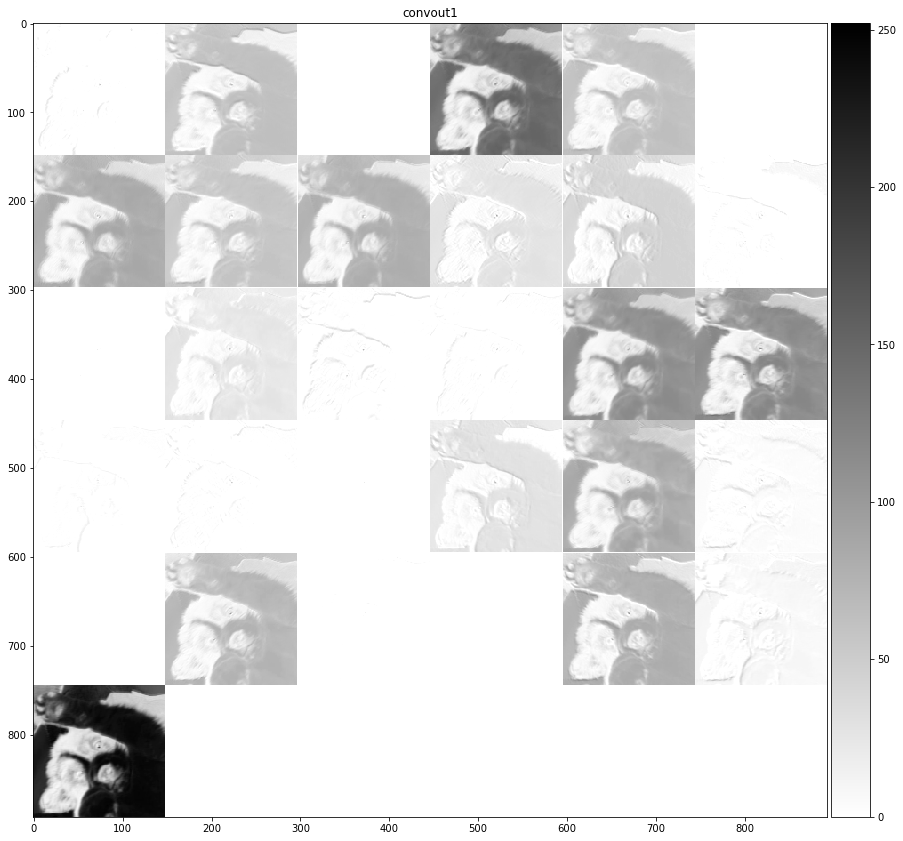

In [90]:
# Visualize first convolutional result (after activation)
import pylab as pl
import matplotlib.cm as cm
C4 = convout4_f([test_image])
C4 = np.squeeze(C4)
print("C4 shape : ", C4.T.shape)

pl.figure(figsize=(15, 15))
pl.title('convout1')
nice_imshow(pl.gca(), make_mosaic(C4.T, 6, 6), cmap=cm.binary)

('C5 shape : ', (32, 146, 146))


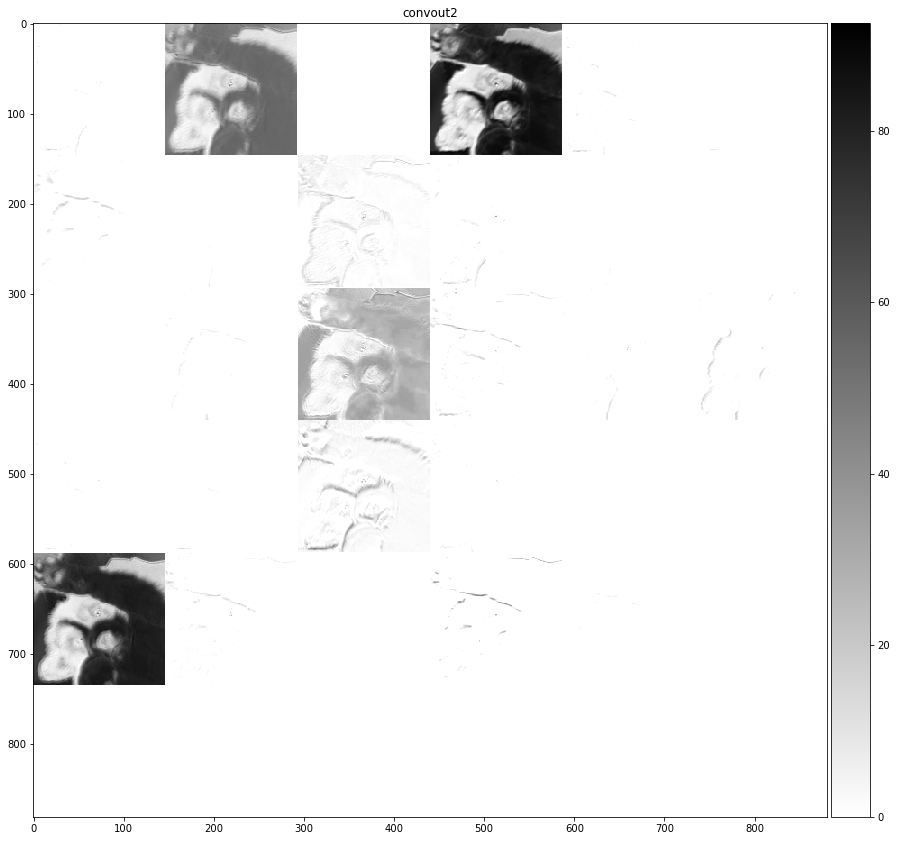

In [97]:
# Visualize second convolution result (after activation)
C5 = convout5_f([test_image])
C5 = np.squeeze(C5)
print("C5 shape : ", C5.T.shape)

pl.figure(figsize=(15, 15))
pl.title('convout2')
nice_imshow(pl.gca(), make_mosaic(C5.T, 6, 6), cmap=cm.binary)

('C6 shape : ', (64, 71, 71))


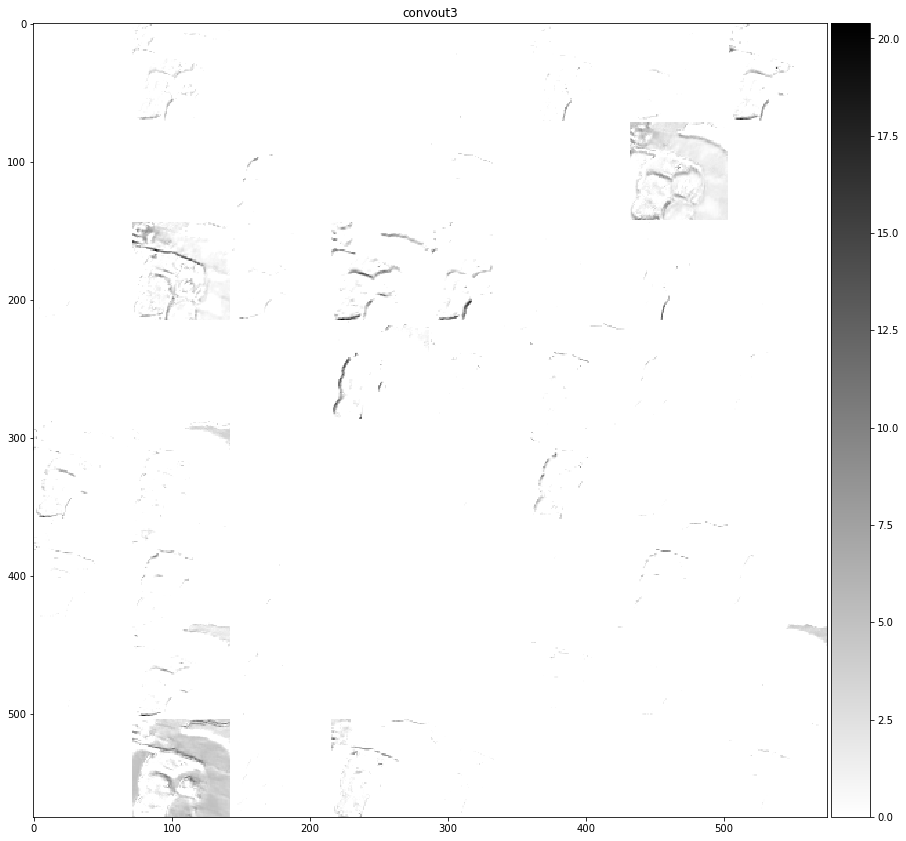

In [100]:
# Visualize third convolution result (after activation)
C6 = convout6_f([test_image])
C6 = np.squeeze(C6)
print("C6 shape : ", C6.T.shape)

pl.figure(figsize=(15, 15))
pl.title('convout3')
nice_imshow(pl.gca(), make_mosaic(C6.T, 8, 8), cmap=cm.binary)

## Confirm if the CNN is convolving

[[ 0.11911119 -0.02943259  0.12195625]
 [ 0.01618152 -0.09725578  0.14140962]
 [-0.05519511  0.0685427  -0.10513386]]


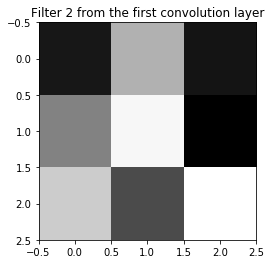

In [91]:
from skimage import color
import scipy.signal

filter_num = 1

test_image_gray = color.rgb2gray(test_image)  # Load the image
kernel = W.T[ filter_num ].T                  # Load the kernel 
plt.title('Filter {} from the first convolution layer'.format(filter_num+1))
plt.imshow(kernel, cmap=cm.binary)
print( kernel )

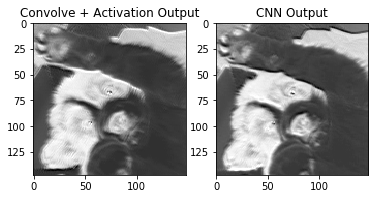

In [92]:
# we use 'valid' which means we do not add zero padding to our image
filtered_image = scipy.signal.convolve2d(test_image_gray, kernel, 'valid')
filtered_image = np.maximum(filtered_image, 0)

# Output using the convolve2d() and maximum() method
plt.subplot(1,2,1)
plt.title('Convolve + Activation Output')
plt.imshow(filtered_image, cmap=cm.binary)

# Output from the CNN's first activation layer, second filter
plt.subplot(1,2,2)
plt.title('CNN Output')
plt.imshow(C4.T[ filter_num ].T, cmap=cm.binary)

## Review

In this tutorial, we explored the following items:
1. Components of CNN
    - Input, CONV, RELU, POOL, FC layers
2. Built a CNN
    - Trained CNN with 1 epoch
    - Tested CNN with loaded weights
3. Examined what CNN learned
    - Filters in a CONV layer
    
<img src="notebook_images/cnn_layers_1.png" width="700">

## Further Reading

The reader is encouraged to implement the additional tasks below to become more familiar with the code and further advance their understanding of convolutional neural network concepts:

1. Convolution (http://machinelearninguru.com/computer_vision/basics/convolution/image_convolution_1.html)
2. Commonly used activation function (http://cs231n.github.io/neural-networks-1/#actfun)
3. Backpropagation (http://cs231n.github.io/optimization-2/)    (http://colah.github.io/posts/2015-08-Backprop/) (http://deeplearning.stanford.edu/wiki/index.php/Backpropagation_Algorithm)
4. Setting up data and model (http://cs231n.github.io/neural-networks-2/)
5. Go the extra step and do Transfer Learning (http://cs231n.github.io/transfer-learning/) (https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

# References 

### CNN architecture

- https://www.kdnuggets.com/2017/09/neural-network-foundations-explained-activation-function.html
- https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/
- http://cs231n.github.io/convolutional-networks/
- https://gggdomi.github.io/keras-workshop/notebook.html
- https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/
- https://www.strong.io/blog/deep-neural-networks-go-to-the-movies

### CNN parameter calculation
- https://stackoverflow.com/questions/28232235/how-to-calculate-the-number-of-parameters-of-convolutional-neural-networks

### External Code
- https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist_v1.ipynb